# 4 - Pre-processing GCM data:

Pre processing GCM data from australian website: [Link to data](https://esgf.nci.org.au/search/esgf-nci/)

## Setting up:

In [1]:
# run script that installs missing libraries
! chmod 755 ../../scripts.sh
! ../../scripts.sh

  Using cached google_cloud_storage-2.3.0-py2.py3-none-any.whl (107 kB)
  Using cached google_cloud_storage-2.2.1-py2.py3-none-any.whl (107 kB)


### Imports:

In [2]:
import os
import sys
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs
import gcsfs
from tqdm import tqdm
import pyproj
from pyproj import Transformer
from google.cloud import storage
from re import search
from os import listdir
from os.path import isfile, join

from GC_scripts import *
from Process_RCM import *
from Reproject_GCM import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Google cloud:

In [3]:
# Google cloud info
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

In [1]:
def listFilesGC_GCM(pathGC, VAR):
    # Get all files already on GC in a bucket
    filesGC = []
    for blob in storage_client.list_blobs(bucket, prefix=pathGC):
        file_ = str(blob)
        if search(f"{VAR}_", file_):
            span = search(f"{VAR}_Amon_ACCESS1-3_(.*?).nc", file_).span(0)
            filesGC.append(file_[span[0] : span[1]])
    return filesGC

## Read raw GCM:
Read raw GCM data stored on Google Cloud.
Variables we want in the GCM:
- Near-Surface Specific Humidity [huss]
- Near-Surface Relative Humidity [hurs]
- Precipitation [pr] 
- Evaporation [evspsbl]
- Near surface air temperature [tas]
- Surface Air Pressure [ps]
- Surface Downwelling Shortwave Radiation [rsds]
- Surface Downwelling Longwave Radiation [rlds]
- Northward Near-Surface Wind [vas]
- Eastward Near-Surface Wind [uas]

In [5]:
shortNames = [
    "zg",
    "wap",
    "vas",
    "va",
    "uas",
    "ua",
    "ts",
    "tauv",
    "tauu",
    "tasmin",
    "tasmax",
    "tas",
    "ta",
    "sfcWind",
    "sci",
    "rtmt",
    "rsutcs",
    "rsut",
    "rsuscs",
    "rsus",
    "rsdt",
    "rsdscs",
    "rsds",
    "rlutcs",
    "rlut",
    "rlus",
    "rldscs",
    "rlds",
    "psl",
    "ps",
    "prw",
    "prsn",
    "prc",
    "pr",
    "huss",
    "hus",
    "hurs",
    "hur",
    "hfss",
    "hfls",
    "evspsbl",
    "clwvi",
    "clw",
    "clt",
    "clivi",
    "cli",
    "cl",
]
longNames = [
    "Geopotential Height",
    "omega (=dp/dt)",
    "Northward Near-Surface Wind",
    " Northward Wind",
    "Eastward Near-Surface Wind",
    "Eastward Wind",
    "Surface Temperature",
    "Surface Downward Northward Wind Stress",
    "Surface Downward Eastward Wind Stress",
    "Daily Minimum Near-Surface Air Temperature",
    "Daily Maximum Near-Surface Air Temperature",
    "Near-Surface Air Temperature",
    "Air Temperature",
    "Near-Surface Wind Speed",
    "Fraction of Time Shallow Convection Occurs",
    "Net Downward Flux at Top of Model",
    "TOA Outgoing Clear-Sky Shortwave Radiation",
    "TOA Outgoing Shortwave Radiation",
    "Surface Upwelling Clear-Sky Shortwave Radiation",
    "Surface Upwelling Shortwave Radiation",
    "TOA Incident Shortwave Radiation",
    "Surface Downwelling Clear-Sky Shortwave Radiation",
    "Surface Downwelling Shortwave Radiation",
    "TOA Outgoing Clear-Sky Longwave Radiation",
    "TOA Outgoing Longwave Radiation",
    "Surface Upwelling Longwave Radiation",
    "Surface Downwelling Clear-Sky Longwave Radiation",
    "Surface Downwelling Longwave Radiation",
    "Sea Level Pressure",
    "Surface Air Pressure",
    "Water Vapor Path",
    "Snowfall Flux",
    "Convective Precipitation",
    "Precipitation",
    "Near-Surface Specific Humidity",
    "Specific Humidity",
    "Near-Surface Relative Humidity",
    "Relative Humidity",
    "Surface Upward Sensible Heat Flux",
    "Surface Upward Latent Heat Flux",
    "Evaporation",
    "Condensed Water Path",
    "Mass Fraction of Cloud Liquid Water",
    "Total Cloud Fraction",
    "Ice Water Path",
    "Mass Fraction of Cloud Ice",
    "Cloud Area Fraction",
]

df = pd.DataFrame(data={"long": longNames, "short": shortNames})
df

,long,short
0,Geopotential Height,zg
1,omega (=dp/dt),wap
2,Northward Near-Surface Wind,vas
3,Northward Wind,va
4,Eastward Near-Surface Wind,uas
5,Eastward Wind,ua
6,Surface Temperature,ts
7,Surface Downward Northward Wind Stress,tauv
8,Surface Downward Eastward Wind Stress,tauu
9,Daily Minimum Near-Surface Air Temperature,tasmin


In [8]:
def BasicPreprocGCM(df, VAR):
    # Slice to same time as RCM:
    Firstdate = datetime(1980, 1, 16, 12, 0, 0)
    Enddate = datetime(2100, 12, 16, 12, 0, 0)
    df = df.sel(time=slice(Firstdate, Enddate))
    
    # remove useless variables
    df = df.drop(["lat_bnds", "lon_bnds", "time_bnds"])
    
    # resample to monthly mean so as to start on same date as RCM
    df = resampleMonthlyMean(df)
    vars_with_height = ["huss", "hurs", "tas", "vas", "uas"]
    if VAR in vars_with_height:
        df = df.drop("height")
    return df

### Read variables and process:
Read variables from google cloud and do some basic pre-processing. 

In [ ]:
vars_ = ["huss", "hurs", "pr", "evspsbl", "tas", "ps", "rsds", "rlds", "vas", "uas"]
download = False
if download:
    ! rm -r ../../../data/tmp/*
    for VAR in vars_:
        print(f"{VAR}:\n--------------")
        pathGC = f"Chris_data/RawData/ACCESS1.3/{VAR}/"
        pathLocal = "../../../data/tmp/"
        filesGC = listFilesGC(pathGC, VAR)

        # ------ Download files from GC
        print("Downloading files from GC")
        downloadFilesFromGC(pathGC, pathLocal, filesGC)

        onlyfiles = filesInDirWithVar(pathLocal, VAR)
        print("Examples of files: \n {}".format(onlyfiles[0]))
        if len(onlyfiles) > 0:
            print("Concatenating...")
            f0 = onlyfiles[0]
            df0 = BasicPreprocGCM(xr.open_dataset(pathLocal + f0), VAR)
            for f in onlyfiles[1:]:
                df = BasicPreprocGCM(xr.open_dataset(pathLocal + f), VAR)
                # concatenate with previous years
                df0 = xr.concat([df0, df], dim="time")

            # save file locally:
            path = "../../data/toGC/"
            name = f"{VAR}_Amon_ACCESS1-3_r1i1p1_monthly.nc"
            df0.to_netcdf(name)

            # upload to GC:
            print("Uploading to GC...")
            print(name)
            pathGC = f"Chris_data/RawData/ACCESS1.3/monthly/"
            uploadFileToGC(pathGC, name)

            # delete file and temporary directory:
            os.remove(name)
            ! rm ../../../data/tmp/*

### Concatenate:

In [19]:
vars_ = ['huss', 'hurs', 'pr', 'evspsbl', 'tas', 'ps', 'rsds', 'rlds', 'vas', 'uas']
pathGC = f'Chris_data/RawData/ACCESS1.3/monthly/'
pathLocal = '../../../data/tmp/'

download = False
if download:
    # names of files on GC
    filesGC = [f'{VAR}_Amon_ACCESS1-3_r1i1p1_monthly.nc' for VAR in vars_]
    
    # download files and store locally
    print('Downloading files...')
    downloadFilesFromGC(pathGC, pathLocal, filesGC)

    # concatenate and save nc file to GC
    f0 = filesGC[0]
    df0 = xr.open_dataset(pathLocal+f0)
    if 'height' in df0.coords:
        df0 = df0.drop('height')
        
    print('Concatenating files...')
    for f1 in filesGC[1:]:
        df1 = xr.open_dataset(pathLocal+f1)
        if 'height' in df0.coords:
            df0 = df0.drop('height')
        
        # these variables have slightly different coordinate system so take lon lat from others
        if ('uas' in f1) or ('vas' in f1):
            pr = xr.open_dataset(pathLocal+'pr_Amon_ACCESS1-3_r1i1p1_monthly.nc')
            df1 = df1.assign_coords({'lat': (('lat'), pr.lat[1:].data), 
                        'lon': (('lon'), pr.lon.data), 
                      })
        df0 = xr.merge([df0,df1])

    # save file locally:
    name = f'ACCESS1-3_monthly_aus.nc'
    df0.to_netcdf(name)

100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


Concatenating files...


In [20]:
df0

<xarray.Dataset>
Dimensions:  (lat: 145, time: 1452, lon: 192)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    huss     (time, lat, lon) float32 ...
    hurs     (time, lat, lon) float32 ...
    pr       (time, lat, lon) float32 ...
    evspsbl  (time, lat, lon) float32 ...
    tas      (time, lat, lon) float32 ...
    ps       (time, lat, lon) float32 ...
    rsds     (time, lat, lon) float32 ...
    rlds     (time, lat, lon) float32 ...
    vas      (time, lat, lon) float32 nan nan nan nan ... 0.0185 0.2015 0.3846
    uas      (time, lat, lon) float32 nan nan nan nan ... -5.174 -5.171 -5.163
Attributes: (12/28)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1.3
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    table_id:               Table Amon (27 April 2011) 9c851218e3842df9a62ef3...
    title:                  ACCESS1-3 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0

### Cut to Antarctica region:

Max and min values of lat: -90.00° -> -40.00° and lon: 0.00° -> 358.12°


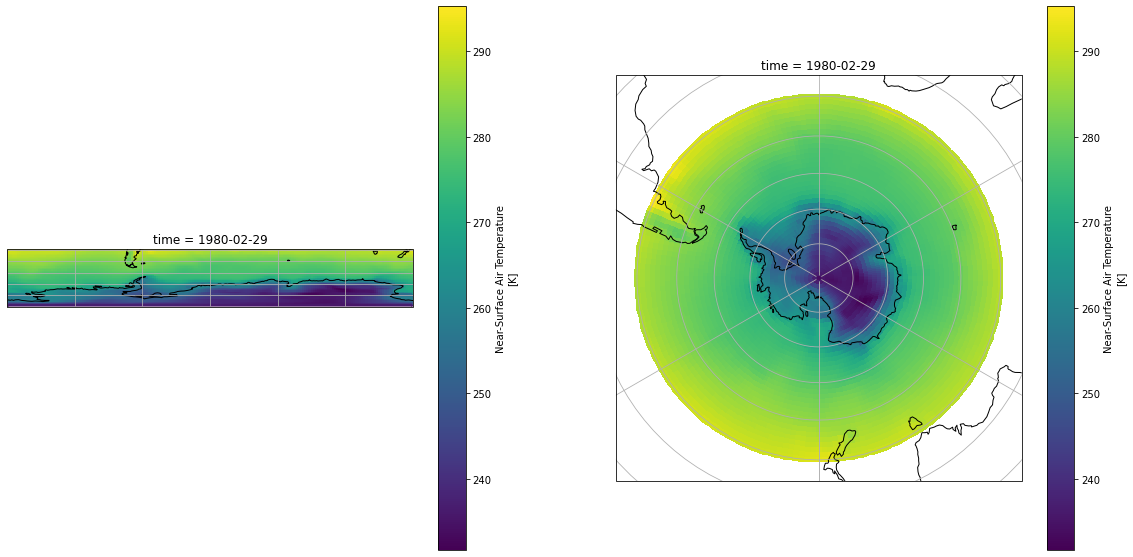

In [24]:
# define antarctica as 90° S to 60° S in latitude and full longitude
# nlimit=-60
nlimit = -40
lat = df0.lat.sel(lat=slice(-90, nlimit))
lon = df0.lon

antarctica = df0.sel(lat=slice(-90, nlimit))

# Define GCM
GCM = antarctica.sortby(["lat", "lon", "time"])
printMaxMin_LatLon(GCM.lat, GCM.lon, unit="°")

# Plot in both projections
f = plt.figure(figsize=(20, 10))
map_proj = ccrs.PlateCarree(central_longitude=0)
ax = plt.subplot(1, 2, 1, projection=map_proj)
antarctica.tas.isel(time=1).plot(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.subplot(1, 2, 2, projection=map_proj)
GCM.tas.isel(time=1).plot(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree())  # data
ax.coastlines()
ax.gridlines()

### Save file to GC:

In [25]:
# save file locally:
name = f"ACCESS1-3_monthly_aus.nc"
GCM.to_netcdf(name)

# upload to GC:
print("Uploading to GC...")
pathGC = f"Chris_data/RawData/ACCESS1.3/monthly/"
uploadFileToGC(pathGC, name)

# delete file and temporary directory:
os.remove(name)
! rm ../../../data/tmp/*

Uploading to GC...
rm: cannot remove '../../../data/tmp/*': No such file or directory
